In [104]:
# Writer : JESOON KANG, Dept. of Computer Science & Engineering in Chung-Ang University
# Last-Modified Date : May 14,2020

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import os
import time
import datetime
from random import *

In [3]:
### Setting up Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Below codes activates when want to use cpu
#device = torch.device('cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

GeForce RTX 2060 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


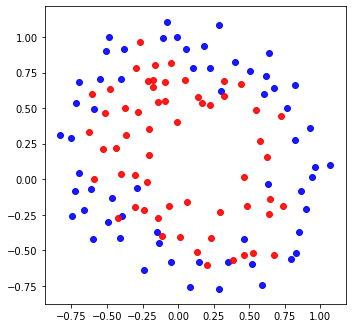

In [4]:
# Plot the training data
import numpy as np
import matplotlib.pyplot as plt

data    = np.genfromtxt("data-nonlinear.txt", delimiter=',')

x       = data[:, 0]
y       = data[:, 1]
label   = data[:, 2]

x_label0    = x[label == 0]
y_label0    = y[label == 0]

x_label1    = x[label == 1]
y_label1    = y[label == 1]

plt.figure(figsize=(5, 5))
plt.scatter(x_label0, y_label0, alpha=0.9, c='b')
plt.scatter(x_label1, y_label1, alpha=0.9, c='r')
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [5]:
x = torch.DoubleTensor(x).to('cuda')
y = torch.DoubleTensor(y).to('cuda')
label = torch.DoubleTensor(label).to('cuda')
x = x.unsqueeze(1)
y = y.unsqueeze(1)
label = label.unsqueeze(1)

In [62]:
def show_graph (thetas) :
    thetas_len = len(thetas)
    mesh_x = torch.linspace(-2,2,256,dtype=torch.double).to('cuda')
    mesh_y = torch.linspace(-2,2,256,dtype=torch.double).to('cuda')
    XX, YY = torch.meshgrid(mesh_x,mesh_y)
    ZZ = get_function(XX,YY)
    
    ZZ = torch.reshape(ZZ,(thetas_len,65536))
    
    ZZ = torch.matmul(thetas.T,ZZ)
    
    ZZ = torch.reshape(ZZ,(256,256))
    
    yh = 1 / (1 + torch.exp(-ZZ))
    plt.figure(figsize=(6, 6))
    plt.scatter(x_label0, y_label0, alpha=0.9, c='b')
    plt.scatter(x_label1, y_label1, alpha=0.9, c='r')
    plt.contour(XX.cpu(), YY.cpu(), yh.cpu(), levels= [0.5], colors='g', alpha=0.6)
    plt.show()

    
def get_running_time(start_time) :
    running_time = datetime.datetime.now() - start_time
    running_time = running_time.seconds
    hours, remainder = divmod(running_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    return hours, minutes, seconds

In [91]:
def show_boundary(thetas_arr) :
    
    thetas_0 = thetas_arr[0]
    thetas_1 = thetas_arr[1]
    thetas_2 = thetas_arr[2]
    thetas_len = len(thetas_0)
    
    mesh_x = torch.linspace(-2,2,256,dtype=torch.double).to('cuda')
    mesh_y = torch.linspace(-2,2,256,dtype=torch.double).to('cuda')
    XX, YY = torch.meshgrid(mesh_x,mesh_y)
    ZZ = get_function(XX,YY)
    #ZZ = torch.reshape(ZZ,(thetas_len,65536))
    

    
    ZZ_0 = torch.matmul(ZZ,thetas_0)
    ZZ_0 = torch.reshape(ZZ_0,(256,256))
    yh_0 = 1 / (1 + torch.exp(-ZZ_0))
    yh_0 = yh_0.squeeze(-1)
    
    ZZ_1 = torch.matmul(ZZ,thetas_1)
    ZZ_1 = torch.reshape(ZZ_1,(256,256))
    yh_1 = 1 / (1 + torch.exp(-ZZ_1))
    yh_1 = yh_1.squeeze(-1)
    
    ZZ_2 = torch.matmul(ZZ,thetas_2)
    ZZ_2 = torch.reshape(ZZ_2,(256,256))
    yh_2 = 1 / (1 + torch.exp(-ZZ_2))
    yh_2 = yh_2.squeeze(-1)
    
    plt.figure(figsize=(6, 6))
    plt.scatter(x_label0, y_label0, alpha=0.9, c='b')
    plt.scatter(x_label1, y_label1, alpha=0.9, c='r')
    plt.contour(XX.cpu(), YY.cpu(), yh_0.cpu(), levels= [0.5], colors='r', alpha=0.8)
    plt.contour(XX.cpu(), YY.cpu(), yh_1.cpu(), levels= [0.5], colors='g', alpha=0.8)
    plt.contour(XX.cpu(), YY.cpu(), yh_2.cpu(), levels= [0.5], colors='b', alpha=0.8)
    plt.show()
    

In [7]:
%%latex
- $g(x, y ; \theta) = \sum_{i=0}^{9} \sum_{j=0}^{9} \theta_{i,j} x^{i} y^{j}$

<IPython.core.display.Latex object>

In [8]:
def get_function(x,y) :    
    ret = []
    for i in range(0,10) :
        for j in range(0,10) :
            ret.append(x**i*y**j)
    ret = torch.stack(ret).squeeze(-1)
    return ret.T


In [10]:

def training(lr,rcp,loss_conv,is_monitor) :
    # Setting Step-size. (Learning-rate)
    lr = lr
    lr = torch.DoubleTensor([lr]).to('cuda')
    # Setting converge value
    loss_conv = loss_conv # loss converge standard

    # rcp : Regularisation_control_param 
    rcp = rcp

    # Lists for logging
    loss_log = []
    epoch_log = []
    acc_log = []
    conv_count = 0 # Variable To count converge
    epoch = 0 # Inital epoch value

    thetas = torch.ones((100,1),dtype=torch.float64).to('cuda')
    fx = get_function(x,y)
    print("#"*60)
    print("Training Setting :\nlr:{}, lambda : {}, loss_conv : {}, monitoring : {}".format(lr.item(),rcp,loss_conv,is_monitor))
    print("#"*60)
    start_time = datetime.datetime.now()
    while (True) :
        epoch +=1
        epoch_log.append(epoch)

        # Get output
        z = torch.matmul(fx,thetas)
        activ_values = 1/(1+torch.exp(-z))
        m = len(activ_values)

        # Calculate Loss
        loss = (1/m) * torch.sum(-label*torch.log(activ_values) - (1-label)*torch.log(1 - activ_values))
        loss += rcp/2*torch.sum(thetas**2)

        for i in range(0,len(thetas)) :
            thetas[i] -= lr * ((1/m)*torch.sum((activ_values-label)*(fx[:,i].unsqueeze(1))) + rcp*thetas[i])

        # Calculate accuracy
        output = activ_values>=0.5
        acc = output.eq(label).sum() * (1/len(activ_values))

        # Logging
        loss_log.append(loss)
        acc_log.append(acc)

        ## Does Train Loss Converged?
        if len(loss_log) > 2 :
            if abs(loss_log[-1] - loss_log[-2]) < loss_conv :
                conv_count += 1
            else :
                conv_count = 0


        # For monitoring
        if epoch %1000 == 0 :        
            running_time = get_running_time(start_time)
            if (is_monitor) :
                print("epoch {},loss {:.10f}, acc {:.3f}, time : {:02d}:{:02d}:{:02d}".\
                      format(epoch,loss_log[-1],acc_log[-1],running_time[0],running_time[1],running_time[2]) )
           
        ## Escape if Training loss is converged
        if conv_count > 4 :
            # Loss converged
            running_time = get_running_time(start_time)
            print("epoch {},loss {:.10f}, acc {:.3f}, time : {:02d}:{:02d}:{:02d}".\
                  format(epoch,loss_log[-1],acc_log[-1],running_time[0],running_time[1],running_time[2]) )

            print("Converged")
            result = {}
            result["epoch_log"] = epoch_log
            result["loss_log"] = loss_log
            result["acc_log"] = acc_log
            result["thetas"] = thetas
            result["lr"] = lr
            result["loss_conv"] = loss_conv
            result["rcp"] = rcp
            result["training_time"] = running_time
            
            return result


In [15]:
final_result = []

lambda_underfit = 0.0001
lambda_justfit = 0.0008
lambda_overfit = 0.2

result_1 = training(1e-2,lambda_underfit,1e-8,False)
final_result.append(result_1)

result_2 = training(1e-2,lambda_justfit,1e-8,False)
final_result.append(result_2)

result_3 = training(1e-2,lambda_overfit,1e-8,False)
final_result.append(result_3)

############################################################
Training Setting :
lr:0.01, lambda : 0.0001, loss_conv : 1e-08, monitoring : False
############################################################
epoch 449122,loss 0.3323885864, acc 0.839, time : 01:09:52
Converged
############################################################
Training Setting :
lr:0.01, lambda : 0.0008, loss_conv : 1e-08, monitoring : False
############################################################
epoch 218186,loss 0.3909640463, acc 0.856, time : 00:33:58
Converged
############################################################
Training Setting :
lr:0.01, lambda : 0.2, loss_conv : 1e-08, monitoring : False
############################################################
epoch 3692,loss 0.6649471932, acc 0.746, time : 00:00:35
Converged


In [ ]:
from IPython.display import display, Math, Latex

# Result Section

## 1. Plot the training data

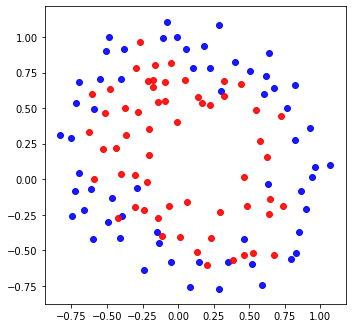

In [16]:
plt.figure(figsize=(5, 5))
plt.scatter(x_label0, y_label0, alpha=0.9, c='b')
plt.scatter(x_label1, y_label1, alpha=0.9, c='r')
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## 2. Plot the training error with varying regularization parameters

Converged Training loss : 
λ1 : 0.3323885864
λ2 : 0.3909640463
λ3 : 0.6649471932


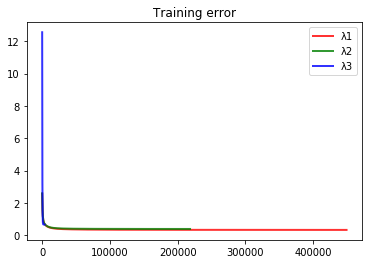

In [103]:
plt.title("Training error")
plot_1, = plt.plot(result_1["epoch_log"],result_1["loss_log"], color='red',linewidth=2,alpha=0.8)
plot_2, = plt.plot(result_2["epoch_log"],result_2["loss_log"], color='green',linewidth=2,alpha=0.8)
plot_3, = plt.plot(result_3["epoch_log"],result_3["loss_log"], color='blue',linewidth=2,alpha=0.8)

plt.legend([plot_1,plot_2,plot_3],["λ1","λ2","λ3"])
print("Converged Training loss : \nλ1 : {:.10f}\nλ2 : {:.10f}\nλ3 : {:.10f}".format(result_1["loss_log"][-1].item(),result_2["loss_log"][-1].item(),result_3["loss_log"][-1].item()))

## 3. Display the values of the chosen regularization parameters

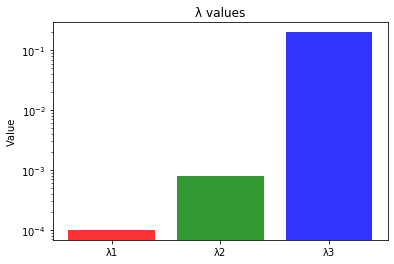

λ1 : 0.0001, λ2 : 0.0008, λ3 : 0.2


In [98]:
ax = plt.subplot2grid((1,1),(0,0))
plt.title("λ values")

plot1 = ax.bar("λ1",result_1["rcp"], color='red',alpha=0.8)
plot2 = ax.bar("λ2",result_2["rcp"], color='green',alpha=0.8)
plot3 = ax.bar("λ3",result_3["rcp"], color='blue',alpha=0.8)
plt.yscale('log')
plt.ylabel("Value")
plt.show()
print("λ1 : {}, λ2 : {}, λ3 : {}".format(result_1["rcp"],result_2["rcp"],result_3["rcp"]))

## 4. Plot the training accuracy with varying regularization parameters

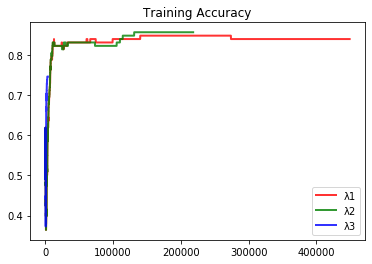

In [94]:
plt.title("Training Accuracy")
plot1, = plt.plot(result_1["epoch_log"],result_1["acc_log"], color='red',linewidth=2,alpha=0.8)
plot2, = plt.plot(result_2["epoch_log"],result_2["acc_log"], color='green',linewidth=2,alpha=0.8)
plot3, = plt.plot(result_3["epoch_log"],result_3["acc_log"], color='blue',linewidth=2,alpha=0.8)
plt.legend([plot1,plot2,plot3],["λ1","λ2","λ3"])
plt.show()

## 5. Display the final training accuracy with varying regularization parameters

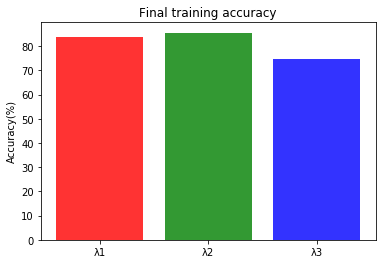

λ1 : 83.89831%, λ2 : 85.59322%, λ3 : 74.57627%


In [102]:
plt.title("Final training accuracy")
plot = plt.bar(["λ1"],result_1["acc_log"][-1].cpu()*100, color='red',alpha=0.8)
plot = plt.bar(["λ2"],result_2["acc_log"][-1].cpu()*100, color='green',alpha=0.8)
plot = plt.bar(["λ3"],result_3["acc_log"][-1].cpu()*100, color='blue',alpha=0.8)

plt.ylabel("Accuracy(%)")
plt.show()
print("λ1 : {:.5f}%, λ2 : {:.5f}%, λ3 : {:.5f}%".format(result_1["acc_log"][-1].cpu()*100,result_2["acc_log"][-1].cpu()*100,result_3["acc_log"][-1].cpu()*100))

# 6. Plot the optimal classifier superimposed on the training data

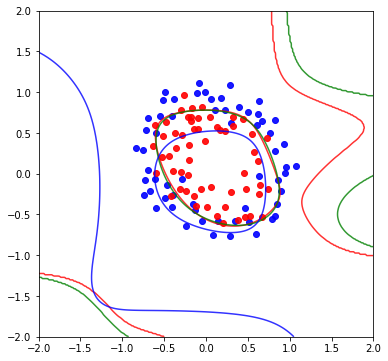

In [92]:
thetas_arr = [result_1["thetas"],result_2["thetas"],result_3["thetas"]]
show_boundary(thetas_arr)